# HIDDEN MARKOV MODEL - WEATHER PREDICTION SYSTEM
===============================================================================
Project: Stochastic Process - Hidden Markov Model Implementation

Implementation includes:
- Hidden States: Cold, Moderate, Hot Weather
- Observable Events: Temperature measurements
- Transition Matrix (A)
- Emission Matrix (B)
- Initial State Probabilities (π)
- Forward Algorithm
- Backward Algorithm
- Viterbi Algorithm (Decoding)
- Baum-Welch Algorithm (Training)
===============================================================================

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## DATA GENERATION MODULE

In [ ]:
class RealWeatherDataLoader:
    """Load real weather data and prepare it for HMM."""
    
    def __init__(self, filepath="../data/weatherHistory.csv", n_samples=1000):
        self.filepath = filepath
        self.n_samples = n_samples
        self.n_states = 3
    
    def load(self):
        # Load the dataset
        try:
            df_raw = pd.read_csv(self.filepath)
            print(f"Successfully loaded {self.filepath}")
        except FileNotFoundError:
            print(f"Error: {self.filepath} not found. Please ensure the file is in the same directory.")
            return None, None, None
            
        # Take a sample to keep processing time reasonable
        # We take the first n_samples to preserve the time-series nature
        df_sample = df_raw.head(self.n_samples).copy()
        
        # Extract observations (Temperature)
        observations = df_sample['Temperature (C)'].values
        
        # Derive "True States" based on temperature bins for comparison/validation
        # We define: 0=Cold (<10°C), 1=Moderate (10-20°C), 2=Hot (>20°C)
        true_states = []
        for temp in observations:
            if temp < 10:
                true_states.append(0) # Cold
            elif temp < 20:
                true_states.append(1) # Moderate
            else:
                true_states.append(2) # Hot
        
        true_states = np.array(true_states)
        
        # Create formatted DataFrame
        df = pd.DataFrame({
            'Day': range(1, self.n_samples + 1),
            'Temperature': observations,
            'True_State': true_states,
            'State_Name': ['Cold' if s==0 else 'Moderate' if s==1 else 'Hot' for s in true_states]
        })
        
        return df, observations, true_states

## HIDDEN MARKOV MODEL CLASS

In [ ]:
class HiddenMarkovModel:
    """Complete HMM implementation with all required algorithms."""
    
    def __init__(self, n_states=3):
        self.n_states = n_states
        self.transition = None
        self.initial = None
        self.emission_means = None
        self.emission_stds = None
        
    def initialize_parameters(self, observations):
        np.random.seed(123)
        
        # Random transition and initial probabilities
        self.transition = np.random.dirichlet(np.ones(self.n_states), size=self.n_states)
        self.initial = np.random.dirichlet(np.ones(self.n_states))
        
        # Initialize emissions using quantiles to ensure ordered states (Cold, Moderate, Hot)
        sorted_obs = np.sort(observations)
        self.emission_means = np.zeros(self.n_states)
        self.emission_stds = np.zeros(self.n_states)
        
        for i in range(self.n_states):
            start = int(i * len(sorted_obs) / self.n_states)
            end = int((i + 1) * len(sorted_obs) / self.n_states)
            chunk = sorted_obs[start:end]
            self.emission_means[i] = chunk.mean()
            self.emission_stds[i] = max(chunk.std(), 0.5)
            
    
    def emission_probability(self, observation, state):
        mean = self.emission_means[state]
        std = self.emission_stds[state]
        prob = norm.pdf(observation, mean, std)
        return max(prob, 1e-100)
    
    
    def forward_algorithm(self, observations):
        T = len(observations)
        alpha = np.zeros((T, self.n_states))
        
        for i in range(self.n_states):
            alpha[0, i] = self.initial[i] * self.emission_probability(observations[0], i)
        
        for t in range(1, T):
            for j in range(self.n_states):
                emission = self.emission_probability(observations[t], j)
                alpha[t, j] = emission * sum(
                    alpha[t-1, i] * self.transition[i, j] 
                    for i in range(self.n_states)
                )
        
        prob_obs = alpha[-1].sum()
        return alpha, prob_obs
    
    
    def backward_algorithm(self, observations):
        T = len(observations)
        beta = np.zeros((T, self.n_states))
        
        beta[-1, :] = 1
        
        for t in range(T-2, -1, -1):
            for i in range(self.n_states):
                beta[t, i] = sum(
                    self.transition[i, j] * 
                    self.emission_probability(observations[t+1], j) * 
                    beta[t+1, j]
                    for j in range(self.n_states)
                )
        
        return beta
    
    
    def viterbi_algorithm(self, observations):
        T = len(observations)
        delta = np.zeros((T, self.n_states))
        psi = np.zeros((T, self.n_states), dtype=int)
        
        for i in range(self.n_states):
            delta[0, i] = self.initial[i] * self.emission_probability(observations[0], i)
        
        for t in range(1, T):
            for j in range(self.n_states):
                emission = self.emission_probability(observations[t], j)
                probs = [delta[t-1, i] * self.transition[i, j] for i in range(self.n_states)]
                delta[t, j] = max(probs) * emission
                psi[t, j] = np.argmax(probs)
        
        best_path = np.zeros(T, dtype=int)
        best_path[-1] = np.argmax(delta[-1])
        
        for t in range(T-2, -1, -1):
            best_path[t] = psi[t+1, best_path[t+1]]
        
        max_prob = delta[-1, best_path[-1]]
        return best_path, max_prob
    
    
    def baum_welch(self, observations, max_iterations=50, tolerance=1e-4):
        T = len(observations)
        log_likelihoods = []
        
        for iteration in range(max_iterations):
            alpha, prob_obs = self.forward_algorithm(observations)
            beta = self.backward_algorithm(observations)
            
            log_likelihood = np.log(prob_obs + 1e-100)
            log_likelihoods.append(log_likelihood)
            
            gamma = np.zeros((T, self.n_states))
            for t in range(T):
                denominator = sum(alpha[t, i] * beta[t, i] for i in range(self.n_states))
                for i in range(self.n_states):
                    gamma[t, i] = (alpha[t, i] * beta[t, i]) / (denominator + 1e-100)
            
            xi = np.zeros((T-1, self.n_states, self.n_states))
            for t in range(T-1):
                denominator = 0
                for i in range(self.n_states):
                    for j in range(self.n_states):
                        xi[t, i, j] = (alpha[t, i] * self.transition[i, j] * 
                                      self.emission_probability(observations[t+1], j) * 
                                      beta[t+1, j])
                        denominator += xi[t, i, j]
                xi[t] /= (denominator + 1e-100)
            
            self.initial = gamma[0]
            
            for i in range(self.n_states):
                for j in range(self.n_states):
                    numerator = xi[:, i, j].sum()
                    denominator = gamma[:-1, i].sum()
                    self.transition[i, j] = numerator / (denominator + 1e-100)
            
            for i in range(self.n_states):
                gamma_sum = gamma[:, i].sum()
                
                self.emission_means[i] = sum(
                    gamma[t, i] * observations[t] for t in range(T)
                ) / (gamma_sum + 1e-100)
                
                self.emission_stds[i] = np.sqrt(
                    sum(gamma[t, i] * (observations[t] - self.emission_means[i])**2 
                        for t in range(T)) / (gamma_sum + 1e-100)
                )
                self.emission_stds[i] = max(self.emission_stds[i], 0.1)
            
            if iteration > 0:
                improvement = log_likelihood - log_likelihoods[-2]
                if abs(improvement) < tolerance:
                    print(f"Converged after {iteration+1} iterations")
                    break
            
            if (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration+1}: Log-Likelihood = {log_likelihood:.4f}")
        
        return log_likelihoods

## VISUALIZATION MODULE

In [6]:
def visualize_complete_results(df, hmm_before, hmm_after, observations, true_states):
    fig = plt.figure(figsize=(20, 14))
    
    state_colors = ['blue', 'green', 'red']
    state_names = ['Cold', 'Moderate', 'Hot']
    
    ax1 = plt.subplot(4, 3, 1)
    for i, name in enumerate(state_names):
        mask = df['True_State'] == i
        ax1.scatter(df[mask]['Day'], df[mask]['Temperature'], 
                   c=state_colors[i], label=name, alpha=0.6, s=20)
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Temperature (°C)')
    ax1.set_title('True Hidden States (Derived)', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = plt.subplot(4, 3, 2)
    pred_before, _ = hmm_before.viterbi_algorithm(observations)
    for i, name in enumerate(state_names):
        mask = pred_before == i
        ax2.scatter(df[mask]['Day'], df[mask]['Temperature'], 
                   c=state_colors[i], label=name, alpha=0.6, s=20, marker='x')
    ax2.set_xlabel('Day')
    ax2.set_ylabel('Temperature (°C)')
    ax2.set_title('Predicted States (Before Training)', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    ax3 = plt.subplot(4, 3, 3)
    pred_after, _ = hmm_after.viterbi_algorithm(observations)
    for i, name in enumerate(state_names):
        mask = pred_after == i
        ax3.scatter(df[mask]['Day'], df[mask]['Temperature'], 
                   c=state_colors[i], label=name, alpha=0.6, s=20, marker='^')
    ax3.set_xlabel('Day')
    ax3.set_ylabel('Temperature (°C)')
    ax3.set_title('Predicted States (After Training)', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    ax4 = plt.subplot(4, 3, 4)
    days_show = min(100, len(df))
    ax4.plot(range(days_show), true_states[:days_show], 
            'b-', label='True', linewidth=2, alpha=0.7)
    ax4.plot(range(days_show), pred_before[:days_show], 
            'r--', label='Before Training', linewidth=2, alpha=0.7)
    ax4.plot(range(days_show), pred_after[:days_show], 
            'g:', label='After Training', linewidth=2, alpha=0.7)
    ax4.set_xlabel('Day')
    ax4.set_ylabel('State')
    ax4.set_title(f'State Sequences (First {days_show} Days)', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    matrices = [
        ('True Transition Matrix', df),
        ('Before Training', hmm_before.transition),
        ('After Training', hmm_after.transition)
    ]
    
    for idx, (title, data) in enumerate(matrices):
        ax = plt.subplot(4, 3, 5 + idx)
        if isinstance(data, pd.DataFrame):
            trans = np.zeros((3, 3))
            for i in range(len(data) - 1):
                trans[data['True_State'].iloc[i], data['True_State'].iloc[i+1]] += 1
            trans = trans / trans.sum(axis=1, keepdims=True)
            matrix = trans
        else:
            matrix = data
        
        sns.heatmap(matrix, annot=True, fmt='.3f', cmap='YlOrRd',
                   xticklabels=state_names, yticklabels=state_names, ax=ax,
                   vmin=0, vmax=1, cbar_kws={'label': 'Probability'})
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.set_xlabel('To State')
        ax.set_ylabel('From State')
    
    ax8 = plt.subplot(4, 3, 8)
    x = np.arange(3)
    width = 0.25
    
    # Note: True means are now derived from data, but we'll use the bin centers as reference
    # Cold < 10 (say 5), Moderate 10-20 (say 15), Hot > 20 (say 25)
    # Or better, calculate actual means from the data for the 'True' bars
    true_means = []
    for i in range(3):
        if (true_states == i).any():
            true_means.append(observations[true_states == i].mean())
        else:
            true_means.append(0)
            
    ax8.bar(x - width, true_means, width, label='True (Data)', color='blue', alpha=0.6)
    ax8.bar(x, hmm_before.emission_means, width, label='Before', color='red', alpha=0.6)
    ax8.bar(x + width, hmm_after.emission_means, width, label='After', color='green', alpha=0.6)
    
    ax8.set_xlabel('State')
    ax8.set_ylabel('Mean Temperature (°C)')
    ax8.set_title('Emission Means Comparison', fontsize=12, fontweight='bold')
    ax8.set_xticks(x)
    ax8.set_xticklabels(state_names)
    ax8.legend()
    ax8.grid(True, alpha=0.3, axis='y')
    
    ax9 = plt.subplot(4, 3, 9)
    acc_before = (pred_before == true_states).sum() / len(true_states) * 100
    acc_after = (pred_after == true_states).sum() / len(true_states) * 100
    
    bars = ax9.bar(['Before Training', 'After Training'], 
                   [acc_before, acc_after],
                   color=['red', 'green'], alpha=0.6)
    ax9.set_ylabel('Accuracy (%)')
    ax9.set_title('Prediction Accuracy', fontsize=12, fontweight='bold')
    ax9.set_ylim(0, 100)
    
    for bar in bars:
        height = bar.get_height()
        ax9.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    ax9.grid(True, alpha=0.3, axis='y')
    
    ax10 = plt.subplot(4, 3, 10)
    for i, name in enumerate(state_names):
        state_temps = df[pred_after == i]['Temperature']
        ax10.hist(state_temps, bins=20, alpha=0.5, 
                 label=f'{name} (n={len(state_temps)})', color=state_colors[i])
    ax10.set_xlabel('Temperature (°C)')
    ax10.set_ylabel('Frequency')
    ax10.set_title('Temperature Distribution (Predicted States)', fontsize=12, fontweight='bold')
    ax10.legend()
    ax10.grid(True, alpha=0.3)
    
    ax11 = plt.subplot(4, 3, 11)
    alpha, _ = hmm_after.forward_algorithm(observations[:50])
    
    for i, name in enumerate(state_names):
        ax11.plot(alpha[:, i], label=name, linewidth=2, color=state_colors[i])
    ax11.set_xlabel('Day')
    ax11.set_ylabel('α(t, state)')
    ax11.set_title('Forward Probabilities (First 50 Days)', fontsize=12, fontweight='bold')
    ax11.legend()
    ax11.grid(True, alpha=0.3)
    ax11.set_yscale('log')
    
    ax12 = plt.subplot(4, 3, 12)
    cm = confusion_matrix(true_states, pred_after)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
               xticklabels=state_names, yticklabels=state_names, ax=ax12,
               cbar_kws={'label': 'Proportion'})
    ax12.set_xlabel('Predicted State')
    ax12.set_ylabel('True State')
    ax12.set_title('Confusion Matrix (After Training)', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('hmm_complete_analysis.png', dpi=300, bbox_inches='tight')
    print("\nVisualizations saved as 'hmm_complete_analysis.png'")
    plt.show()
    
    return acc_before, acc_after

## MAIN EXECUTION

                         HIDDEN MARKOV MODEL PROJECT
                    Weather Prediction with Baum-Welch Training

STEP 1: Loading Real Weather Dataset
------------------------------------------------------------------------------------------
Successfully loaded weatherHistory.csv
Loaded 1000 days of weather data

Dataset Preview:
   Day  Temperature  True_State State_Name
0    1     9.472222           0       Cold
1    2     9.355556           0       Cold
2    3     9.377778           0       Cold
3    4     8.288889           0       Cold
4    5     8.755556           0       Cold
5    6     9.222222           0       Cold
6    7     7.733333           0       Cold
7    8     8.772222           0       Cold
8    9    10.822222           1   Moderate
9   10    13.772222           1   Moderate

Temperature Range: 1.0°C - 32.5°C
Mean Temperature: 15.1°C


STEP 2: Initialize HMM with Random Parameters
-----------------------------------------------------------------------------------

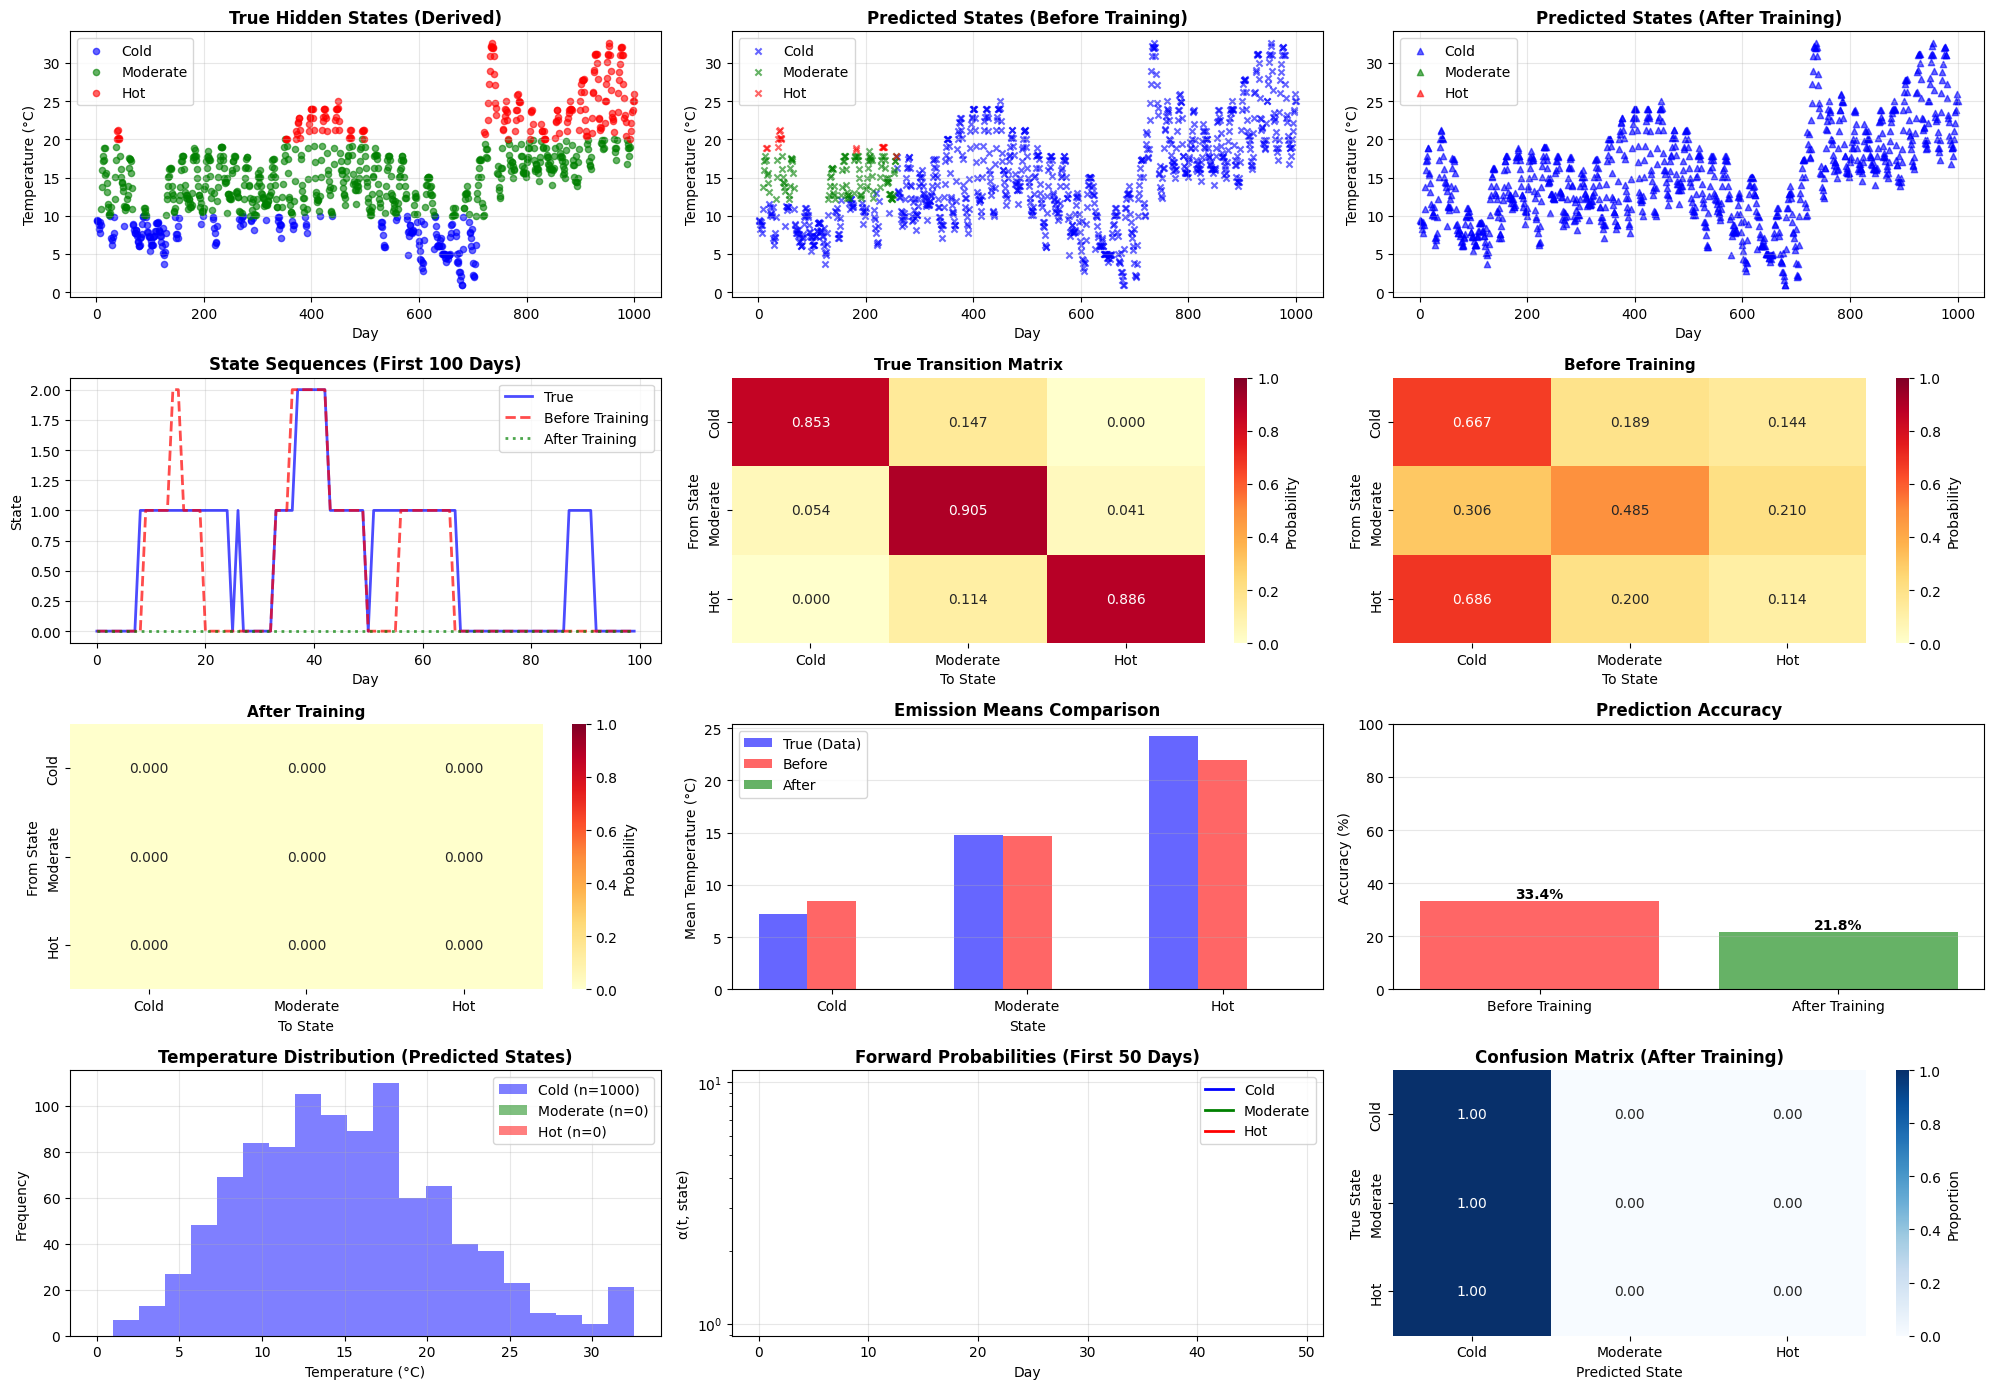



                                   PROJECT COMPLETE

Summary:
  Dataset Size: 1000 days
  Number of States: 3 (Cold, Moderate, Hot)
  Accuracy Improvement: 33.4% → 21.8% (+-11.6%)

Algorithms Implemented:
  - Forward Algorithm
  - Backward Algorithm
  - Viterbi Algorithm (Decoding)
  - Baum-Welch Algorithm (Training)

Files Generated:
  - hmm_complete_analysis.png (12 comprehensive visualizations)
    


In [7]:
def main():
    print("="*90)
    print(" " * 25 + "HIDDEN MARKOV MODEL PROJECT")
    print(" " * 20 + "Weather Prediction with Baum-Welch Training")
    print("="*90)
    
    print("\nSTEP 1: Loading Real Weather Dataset")
    print("-" * 90)
    # Use RealWeatherDataLoader instead of generator
    loader = RealWeatherDataLoader(n_samples=1000)
    df, observations, true_states = loader.load()
    
    if df is None:
        return
    
    print(f"Loaded {len(df)} days of weather data")
    print(f"\nDataset Preview:")
    print(df.head(10))
    print(f"\nTemperature Range: {observations.min():.1f}°C - {observations.max():.1f}°C")
    print(f"Mean Temperature: {observations.mean():.1f}°C")
    
    print("\n\nSTEP 2: Initialize HMM with Random Parameters")
    print("-" * 90)
    hmm_before = HiddenMarkovModel(n_states=3)
    hmm_before.initialize_parameters(observations)
    
    print("Initial Parameters (Quantile-based):")
    print(f"  Emission Means: {hmm_before.emission_means}")
    print(f"  Emission Stds: {hmm_before.emission_stds}")
    print(f"  Transition Matrix:")
    for i, row in enumerate(hmm_before.transition):
        print(f"    State {i}: {row}")
    
    print("\n\nSTEP 3: Testing Algorithms (Before Training)")
    print("-" * 90)
    
    print("Running Forward Algorithm...")
    alpha, forward_prob = hmm_before.forward_algorithm(observations)
    print(f"  P(Observations | Model) = {forward_prob:.2e}")
    
    print("\nRunning Backward Algorithm...")
    beta = hmm_before.backward_algorithm(observations)
    print(f"  Backward algorithm completed")
    
    print("\nRunning Viterbi Algorithm...")
    pred_before, viterbi_prob = hmm_before.viterbi_algorithm(observations)
    acc_before = (pred_before == true_states).sum() / len(true_states)
    print(f"  Most likely state sequence found")
    print(f"  Accuracy (vs Derived States): {acc_before:.2%}")
    
    print("\n\nSTEP 4: Training with Baum-Welch Algorithm")
    print("-" * 90)
    print("Starting Expectation-Maximization training...\n")
    
    hmm_after = HiddenMarkovModel(n_states=3)
    hmm_after.initialize_parameters(observations)
    log_likelihoods = hmm_after.baum_welch(observations, max_iterations=50)
    
    print(f"\nTraining completed!")
    print(f"  Final Log-Likelihood: {log_likelihoods[-1]:.4f}")
    print(f"  Improvement: {log_likelihoods[-1] - log_likelihoods[0]:.4f}")
    
    print("\n\nSTEP 5: Testing After Training")
    print("-" * 90)
    
    pred_after, _ = hmm_after.viterbi_algorithm(observations)
    acc_after = (pred_after == true_states).sum() / len(true_states)
    
    print(f"Accuracy (vs Derived States): {acc_after:.2%}")
    print(f"Improvement: {(acc_after - acc_before)*100:.1f}%")
    
    print("\n\nSTEP 6: Parameter Comparison")
    print("-" * 90)
    
    print("\nEmission Means:")
    # Calculate true means from data for comparison
    true_means = []
    for i in range(3):
        if (true_states == i).any():
            true_means.append(observations[true_states == i].mean())
        else:
            true_means.append(0)
    print(f"  True (Data): {true_means}")
    print(f"  Before: {hmm_before.emission_means}")
    print(f"  After:  {hmm_after.emission_means}")
    
    print("\nTransition Matrix (After Training):")
    for i, row in enumerate(hmm_after.transition):
        print(f"  From State {i}: {row}")
    
    print("\nInitial Probabilities:")
    print(f"  {hmm_after.initial}")
    
    print("\n\nSTEP 7: Detailed Analysis")
    print("-" * 90)
    
    print("\nState Distribution:")
    print(f"  True States (Derived):")
    for i, name in enumerate(['Cold', 'Moderate', 'Hot']):
        count = (true_states == i).sum()
        print(f"    {name}: {count} days ({count/len(true_states)*100:.1f}%)")
    
    print(f"\n  Predicted States (After Training):")
    for i, name in enumerate(['Cold', 'Moderate', 'Hot']):
        count = (pred_after == i).sum()
        print(f"    {name}: {count} days ({count/len(true_states)*100:.1f}%)")
    
    print("\n\nSTEP 8: Creating Visualizations")
    print("-" * 90)
    acc_before_viz, acc_after_viz = visualize_complete_results(
        df, hmm_before, hmm_after, observations, true_states
    )
    
    print("\n\n" + "="*90)
    print(" " * 35 + "PROJECT COMPLETE")
    print("="*90)
    print(f"""
Summary:
  Dataset Size: {len(df)} days
  Number of States: 3 (Cold, Moderate, Hot)
  Accuracy Improvement: {acc_before:.1%} → {acc_after:.1%} (+{(acc_after-acc_before)*100:.1f}%)
  
Algorithms Implemented:
  - Forward Algorithm
  - Backward Algorithm
  - Viterbi Algorithm (Decoding)
  - Baum-Welch Algorithm (Training)
  
Files Generated:
  - hmm_complete_analysis.png (12 comprehensive visualizations)
    """)
    
    return df, hmm_before, hmm_after, observations, true_states

if __name__ == "__main__":
    df, hmm_before, hmm_after, obs, states = main()